In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pymongo import MongoClient
import copy
import math
from enum import Enum
import json
import pprint
from os import listdir
import dill
dill.settings['recurse'] = True
from pathos.multiprocessing import ProcessingPool as Pool
import time
from pqdict import PQDict

userRatingPath = "./data/"

class CollectibleType(Enum):
  All = 1
  Hands = 2
  Feet = 3
  Left = 4
  Right = 5
  LeftHand = 6
  RightHand = 7
  LeftFoot = 8
  RightFoot = 9

gravity = 9.81

# Begin Serialization
# Get levels from database
client = MongoClient('localhost', 27017)
db = client['beatfork']
versions = db.versions.find()

# Remove duplicates
def objectDedupe(version):
  lastObject = version['objects'][0]
  for i in range(1, len(version['objects'])):
    if (lastObject['type'] == version['objects'][i]['type'] and
        (lastObject['type'] == 'Obstacle' or lastObject['collectibleType'] == version['objects'][i]['collectibleType']) and
        lastObject['position']['x'] == version['objects'][i]['position']['x'] and
        lastObject['position']['y'] == version['objects'][i]['position']['y'] and
        lastObject['position']['z'] == version['objects'][i]['position']['z']):
       version['objects'][i] = None
    else:
        lastObject = version['objects'][i] 
  version['objects'] = list(filter(lambda o: o, version['objects']))
  return version
versions = list(map(objectDedupe, versions))

# Transform to more efficient data structures
def transformPositionToArray(version):
  version['objects'] = list(map(lambda obj:
  [
    obj['position']['x'],
    obj['position']['y'],
    obj['position']['z'],
    obj['collectibleType'] if obj['type'] == "Collectible" else 0
  ]
  , version['objects']))
  return version
versions = list(map(transformPositionToArray, versions))
# End Serialization

# Import reference data
userRatings = {}
for fileName in listdir(userRatingPath):
  file = open(userRatingPath + fileName)
  userRating = json.load(file)
  id = userRating['_id']['levelId'] + '/' + userRating['_id']['versionId']
  if not id in userRatings:
    userRatings[id] = {
      'overallDifficulty': [],
      'chunkDifficulties': []
    }
  userRatings[id]['overallDifficulty'].append(userRating['overallDifficulty'])
  userRatings[id]['chunkDifficulties'].append(userRating['chunkDifficulties'])
for version in userRatings:
  userRatings[version]['overallDifficulty'] = pd.DataFrame(userRatings[version]['overallDifficulty'])
  userRatings[version]['chunkDifficulties'] = pd.DataFrame(userRatings[version]['chunkDifficulties'])

# Set plot size
sns.set(rc={'figure.figsize': (10, 3)})

In [14]:
chunkSize = 8
overlap = 0

# The method split was copied from Stack Overflow and slightly adjusted.
# https://stackoverflow.com/questions/312443/how-do-i-split-a-list-into-equally-sized-chunks
# For research purposes I am allowed to use it through § 60c Wissenschaftliche Forschung - Gesetz über Urheberrecht und verwandte Schutzrechte (Urheberrechtsgesetz)
def split(myList, chunkSize, overlap=0):
  for i in range (0, len(myList), chunkSize):
    yield myList[i: i + chunkSize + overlap]

# Begin Plot Output
def plotBestOptions(options, chunkSize, graphLimit):

  def removeInf(option):
    for limb in option.values():
      if limb == math.inf:
        option = {
          6: 0,
          7: 0,
          8: 0,
          9: 0,
        }
        return option
    return option

  for version in options:
    fig, ax = plt.subplots()
    plt.ylim([0, graphLimit]) # todo

    options[version] = list(map(removeInf, options[version]))

    chunkLabels = list(range(0, len(options[version])))
    leftHandIntensity = np.array(list(map(lambda option:
      option[CollectibleType.LeftHand.value]
      , options[version])))
    rightHandIntensity = np.array(list(map(lambda option:
      option[CollectibleType.RightHand.value]
      , options[version])))
    leftFootIntensity = np.array(list(map(lambda option:
      option[CollectibleType.LeftFoot.value]
      , options[version])))
    rightFootIntensity = np.array(list(map(lambda option:
      option[CollectibleType.RightFoot.value]
      , options[version])))
    ax.bar(chunkLabels, leftHandIntensity, label='Left Hand', bottom = np.add(leftFootIntensity, rightFootIntensity), zorder=1)
    ax.bar(chunkLabels, rightHandIntensity, label='Right Hand', bottom = np.add(np.add(leftFootIntensity, rightFootIntensity), leftHandIntensity), zorder=1)
    ax.bar(chunkLabels, leftFootIntensity, label='Left Foot', zorder=1)
    ax.bar(chunkLabels, rightFootIntensity, label='Right Foot', bottom=leftFootIntensity, zorder=1)
    ax.legend()

    ax.boxplot(userRatings[version]['chunkDifficulties'], positions=list(range(0, userRatings[version]['chunkDifficulties'].shape[1])), zorder=2)

    plt.title(version)
    plt.xlabel("chunk")
    plt.ylabel("difficulty")

    plt.show()
# End Plot Output

In [15]:
# Begin Traversal
#
# traverseChunk
#
# Inputs
# objects: list of game objects
# state: object
# lastPosition: {
#	  6: number[], (last left hand position)
#	  7: number[], (last right hand position)
#	  8: number[], (last left foot position)
#	  9: number[], (last right foot position)
# }
# transitionDifficultyEstimator: (collectible, state, lastPosition) => number
# trace: string
#
# Outputs
# cumulatedIntensity: {
#	  6: number, (last left hand cumulated intensity)
#	  7: number, (last right hand cumulated intensity)
#	  8: number, (last left foot cumulated intensity)
#	  9: number, (last right foot cumulated intensity)
# }
# state: object
# startPositions: same as lastPosition
# trace: string
def traverseChunk(objects, state, lastPosition, transitionDifficultyEstimator, trace):
  noVertices = 4 ** (len(objects) + 1) + 1
  transitionDifficulties = [math.inf] * noVertices
  transitionDifficulties[0] = 0
  nodes = PQDict(zip(range(noVertices), transitionDifficulties))
  cumulatedIntensities = [{
      6: 0,
      7: 0,
      8: 0,
      9: 0,
    }] * noVertices
  lastPositions = [lastPosition] * noVertices
  states = [state] * noVertices

  for currentNode, currentIntensity in nodes.popitems():
    depth = math.floor(math.log(12 * currentNode + 4, 4) - 1)
    if depth == len(objects) or currentIntensity == math.inf:
      # Start adding taken path to trace
      i = currentNode
      limbStrings = ['lh', 'rh', 'lf', 'rf']
      newTracePart = ''
      while i > 0:
        newTracePart = limbStrings[(i - 1) % 4] + ' ' + newTracePart
        depth = math.floor(math.log(12 * i + 4, 4) - 1) - 1
        i = (i - 1) // 4
      # End adding taken path to trace
      if (currentIntensity == math.inf):
        print('Chunk is impossible!')
        newTracePart += '\nAbove chunk is impossible!'
      return (
        cumulatedIntensities[currentNode],
        states[currentNode],
        lastPositions[currentNode],
        trace + newTracePart + '\n' 
      )
    for i in range(1, 5):
      nodeLabel = 4 * currentNode + i 
      objType = objects[depth][3]
      if (objType == 1 
          or (objType == 2 and (i == 1 or i == 2))
          or (objType == 3 and (i == 3 or i == 4))
          or (objType == 4 and (i == 1 or i == 3))
          or (objType == 5 and (i == 2 or i == 4))
          or objType == 5 + i):
        obj = copy.deepcopy(objects[depth])
        obj[3] = 5 + i
        intensity, s = transitionDifficultyEstimator(obj, states[currentNode], lastPositions[currentNode])
        cumulatedIntensities[nodeLabel] = copy.deepcopy(cumulatedIntensities[currentNode])
        cumulatedIntensities[nodeLabel][5 + i] += intensity
        states[nodeLabel] = s
        lastPositions[nodeLabel] = copy.deepcopy(lastPositions[currentNode])
        lastPositions[nodeLabel][5 + i] = [objects[depth][0], objects[depth][1], objects[depth][2]]
        nodes[nodeLabel] = (
          (cumulatedIntensities[nodeLabel][6] ** 2) +
          (cumulatedIntensities[nodeLabel][7] ** 2) +
          (cumulatedIntensities[nodeLabel][8] ** 2) +
          (cumulatedIntensities[nodeLabel][9] ** 2)
        )
      elif objType == 0:
        cumulatedIntensities[nodeLabel] = copy.deepcopy(cumulatedIntensities[currentNode])
        states[nodeLabel] = copy.deepcopy(states[currentNode])
        lastPositions[nodeLabel] = copy.deepcopy(lastPositions[currentNode])
        nodes[nodeLabel] = currentIntensity

def traverseLevel(version, calcIntensity):
  tStart = time.time()
  chunks = list(split(version['objects'], chunkSize))
  startPositions = {
    6: [-0.3, 0, 0],
    7: [0.3, 0, 0],
    8: [-0.2, -1, 0],
    9: [0.2, -1, 0]
  }
  id = str(version['_id']['levelId']) + '/' + str(version['_id']['versionId'])
  bestOption = []
  state = {}
  trace = ''
  for chunk in chunks:
    cumulatedIntensity, state, startPositions, trace = traverseChunk(
      chunk,
      state,
      startPositions,
      calcIntensity,
      trace
      )
    bestOption.append(cumulatedIntensity)
  return {
    'id': id,
    'option': bestOption,
    'executionTime': time.time() - tStart,
    'trace': trace
  }

def traverseAndPlotAll(transitionDifficultyEstimator, graphLimit=20):
  bestOptions = {}
  # single threaded execution, better for debugging as print statements are visible
  # for version in list(copy.deepcopy(versions)):
  #   result = determineBestOptionDijkstra(version, calcIntensity)
  #   bestOptions[result['id']] = result['option']
  #   print(f'trace{result["trace"]}')

  # parallel execution, better for performance
  noWorkers = len(versions)
  p = Pool(noWorkers)
  results = p.map(traverseLevel, list(copy.deepcopy(versions)), [transitionDifficultyEstimator] * noWorkers)
  for result in results:
    print(f'{result["id"]} took {result["executionTime"]:.3f}s to process.')
    print(f'trace{result["trace"]}')
    print('\n'.join(json.dumps(e) for e in result['option']))
    print('')
    bestOptions[result['id']] = result['option']
  plotBestOptions(bestOptions, chunkSize, graphLimit)
# End Traversal

62f9ef36bd98f54e374d1f42/1 took 4.105s to process.
tracerh rh lh lf rf rf lh rf 
lf rh lf rf lh rh lh rf 
lf rh lf rf lh rf lf lh 
lf lh rh rf rh lh rh lf 
rf lh rh lf lh rf lf rh 
rf lh rf rh lh lf rf rh 
lh lf rh rf lh lf rh rf 
rf rh lf 

{"6": 0.2467333589533346, "7": 0.20899529940082626, "8": 0.14625173087362558, "9": 0.31401831534850366}
{"6": 0.011146618668618534, "7": 0.2434691421720327, "8": 0.23770361913936336, "9": 0.16548060350511126}
{"6": 0.012435994694760234, "7": 0.18955054656979203, "8": 0.027466310828258334, "9": 0.1950118953734074}
{"6": 0.18347794833995715, "7": 0.14531689342744253, "8": 0.0967989401261622, "9": 0.0730304067268928}
{"6": 0.05733886439854154, "7": 0.23999543402498189, "8": 0.03191315453236807, "9": 0.09639849240024596}
{"6": 0.42890621802787976, "7": 0.25440721284786993, "8": 0.1510187980072304, "9": 0.6538993119526921}
{"6": 0.30776408549896395, "7": 0.3656069543685012, "8": 0.30535065237677156, "9": 0.3687015249028428}
{"6": 0, "7": 0.1920897079178

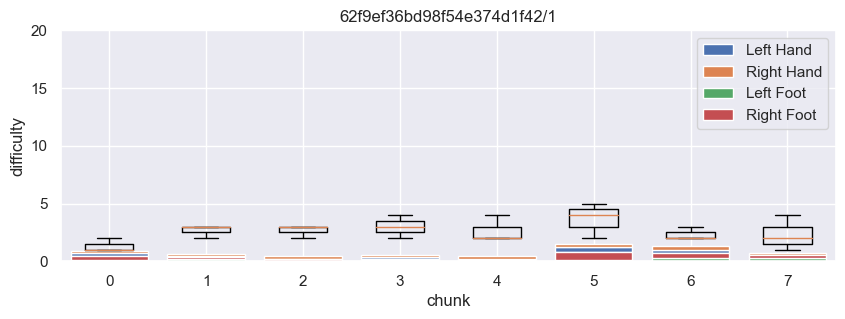

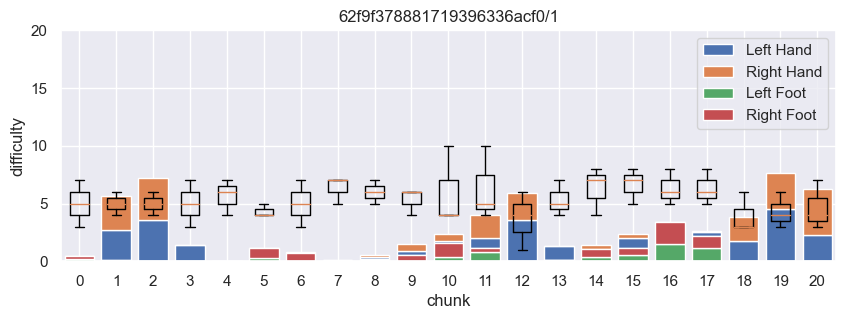

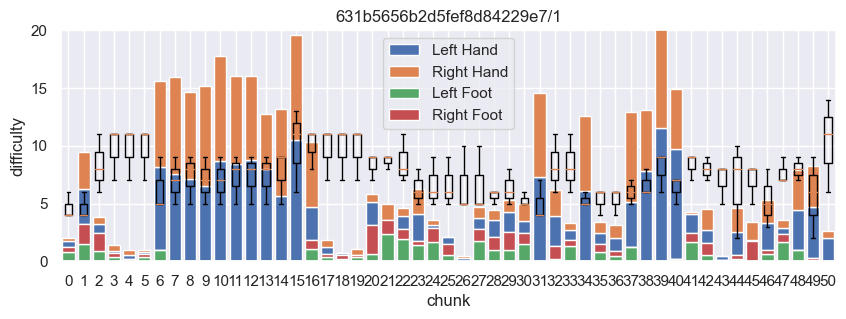

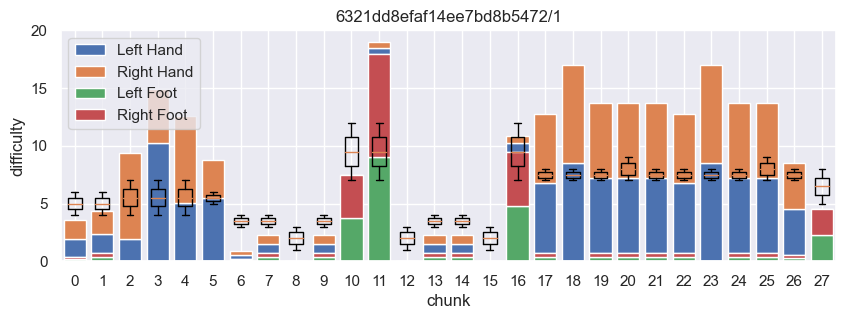

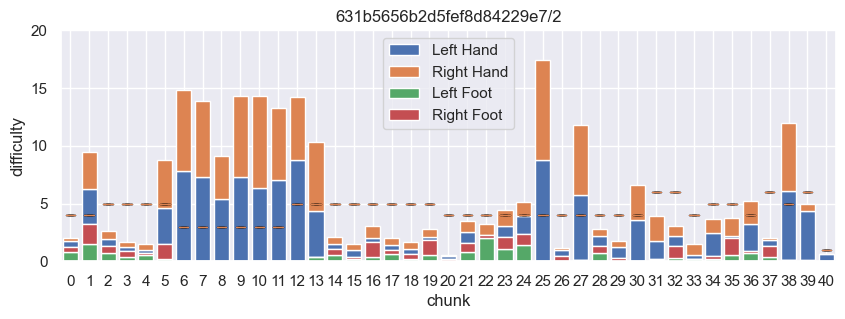

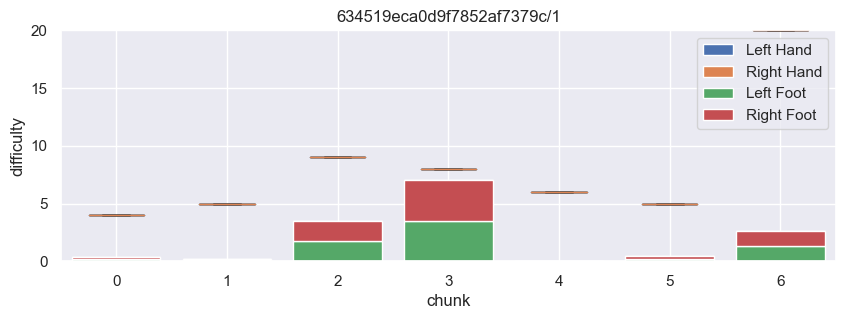

In [16]:
def distanceOverTime(obj, state, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 
    + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])
  if (time == 0):
    return math.inf, state
  if (distance == 0):
    return 0, state
  return distance / time, state

traverseAndPlotAll(distanceOverTime, 20)

62f9ef36bd98f54e374d1f42/1 took 3.831s to process.
tracerh rh rh rh rf lf lh rf 
lf rh lf rf lh rh lh rh 
lf rh lf rh lh rh lf lh 
lf lh rh lh rh lh rh rf 
rh lh lh rf lh rh rf lf 
rh lh rh lf rh lh rf lh 
rh lh rf lh rh lh lf rh 
rh lf rf 

{"6": 0.2792468193618608, "7": 0.36490237053204844, "8": 0.15773779628337486, "9": 0.26956385911669173}
{"6": 0.06131073241687453, "7": 0.27077457243207453, "8": 1.2047123526486627, "9": 0.07005578583385637}
{"6": 0.06825962301989397, "7": 0.3165030858950989, "8": 0.14527069790594546, "9": 0}
{"6": 0.4008332478728408, "7": 0.1604749551600269, "8": 0.032161196427693876, "9": 0.22925200730766482}
{"6": 0.8231557820922424, "7": 0.457008870884371, "8": 0.196602918337778, "9": 0.292958059983262}
{"6": 1.0024712056839944, "7": 1.9251064484510156, "8": 0.5084190282260084, "9": 0.32075127894723077}
{"6": 0.9203905580045245, "7": 0.832400743905662, "8": 1.0038174757156104, "9": 0.7467179003322775}
{"6": 0, "7": 1.6588706205492214, "8": 1.013940318208045, "9

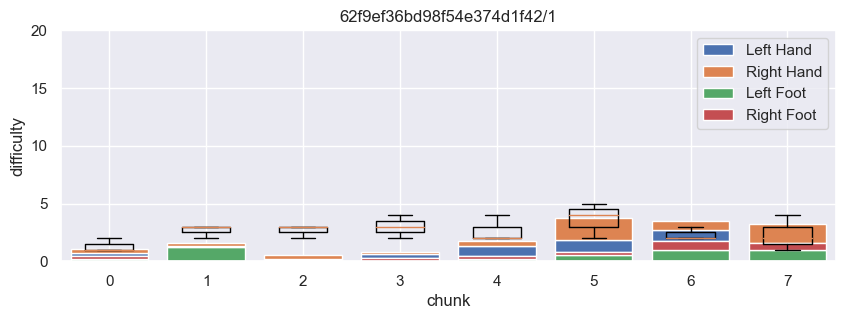

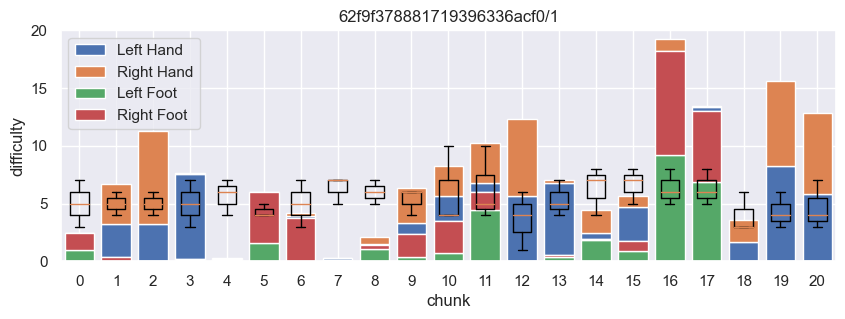

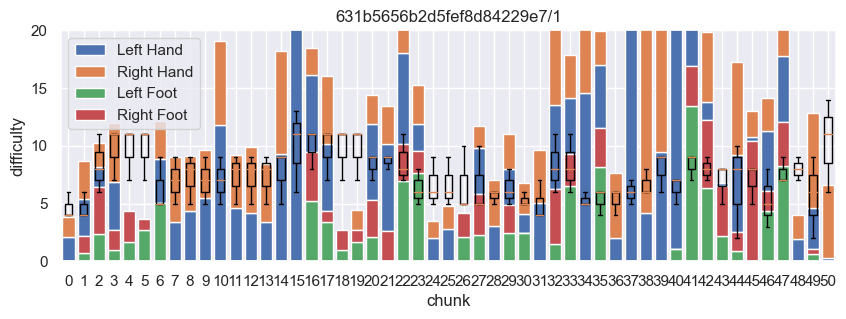

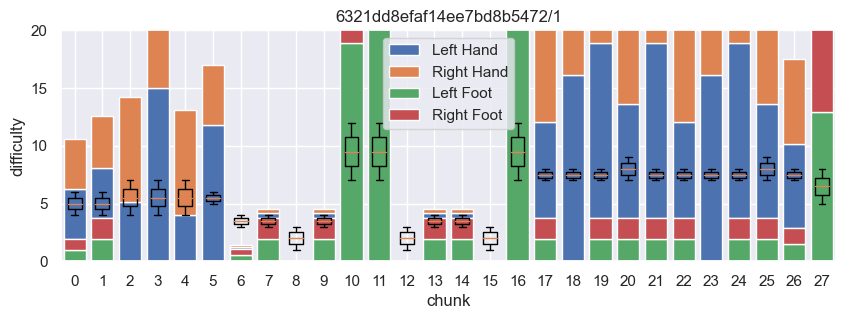

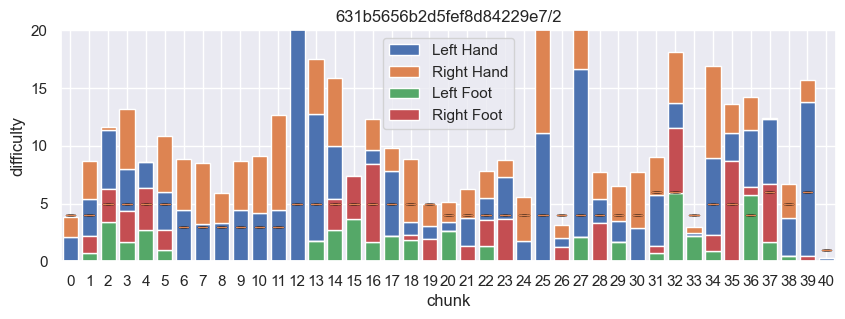

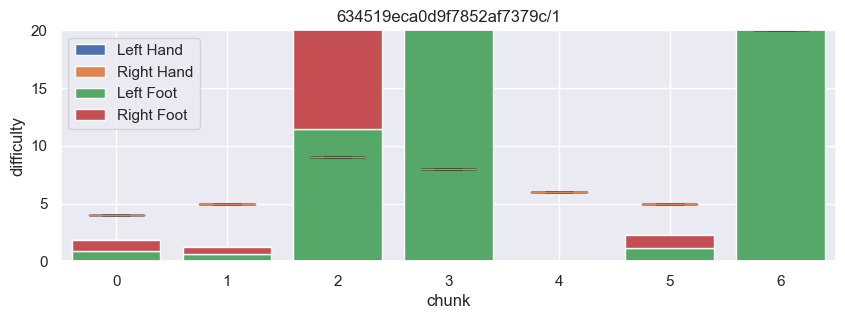

In [17]:
def weight(obj):
  # Hands
  if (obj[3] == 6 or obj[3] == 7):
    return (1.2 * obj[1] - 0.75) ** 4 - (0.2 * obj[1]) ** 6 + 0.5
  # Feet
  else:
    return (obj[1] + 1.4) ** 5 + 5

def weightedDistanceOverTime(obj, state, lastPositions):
  return distanceOverTime(obj, state, lastPositions)[0] * weight(obj), state

traverseAndPlotAll(weightedDistanceOverTime, 20)

62f9ef36bd98f54e374d1f42/1 took 3.648s to process.
tracerh rh rh rh rf lf lh rf 
lf rh lf rf lh rh lh rh 
lf rh lf rh lh rh lf lh 
lf lh rh lh rh lh rh rf 
rh lh lh rf lh rh rh lf 
lh rh rf lf lh rh lh rh 
lh rh rh lh lh rh lh rf 
lf lh rh 

{"6": 0.2792468193618608, "7": 0.36490237053204844, "8": 0.15773779628337486, "9": 0.26956385911669173}
{"6": 0.06131073241687453, "7": 0.27077457243207453, "8": 1.2047123526486627, "9": 0.07005578583385637}
{"6": 0.06825962301989397, "7": 0.3165030858950989, "8": 0.14527069790594546, "9": 0}
{"6": 0.4008332478728408, "7": 0.1604749551600269, "8": 0.032161196427693876, "9": 0.22925200730766482}
{"6": 0.8231557820922424, "7": 0.7556464700615013, "8": 0.196602918337778, "9": 0.2548154693666715}
{"6": 1.2047625741623635, "7": 0.9976345600010221, "8": 0.5084190282260084, "9": 0.8691621813062868}
{"6": 1.5823072708300083, "7": 0.9295629035639074, "8": 0, "9": 0.32017447571475616}
{"6": 1.0704153747467438, "7": 1.3161315836780323, "8": 0.7292335017303919

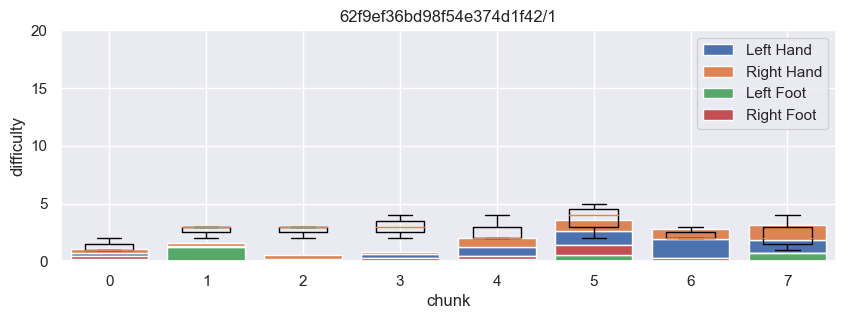

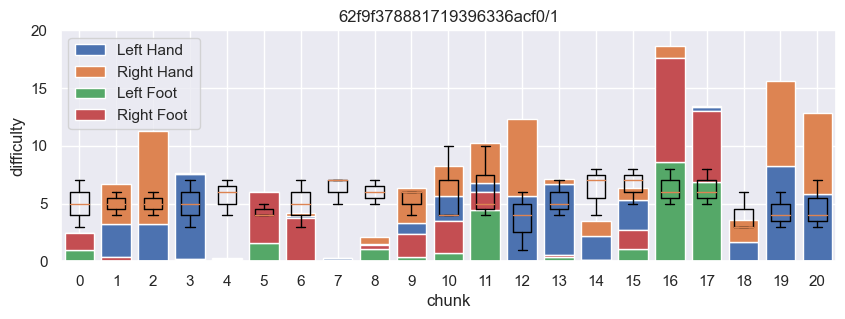

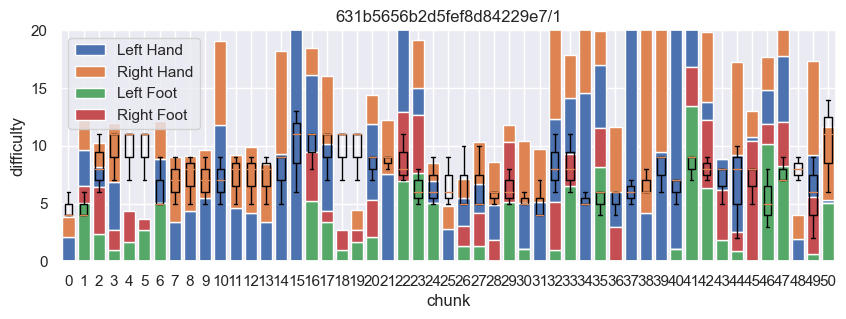

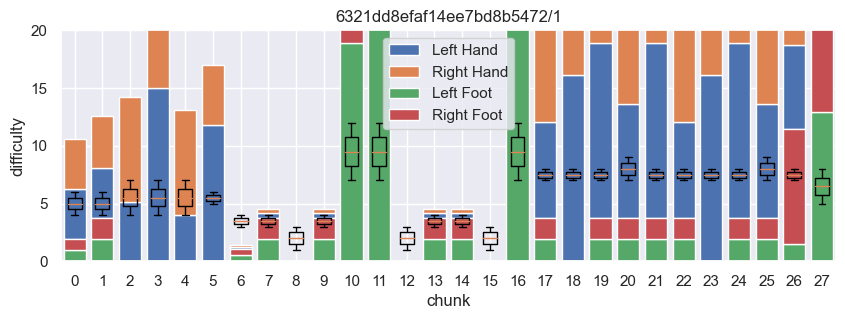

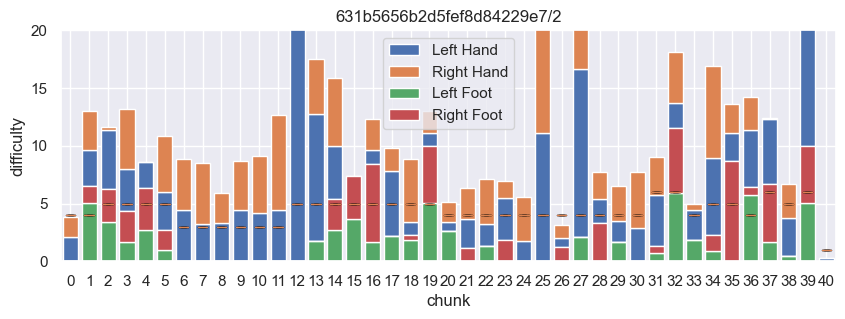

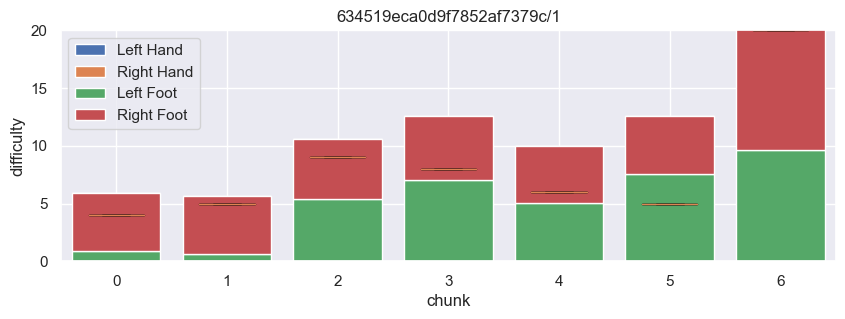

In [18]:
jumpThresholdH = -0.8
jumpThresholdT = 0.5

def jumpHeightDifficulty(height):
  return 3 * (height + 0.5) ** 3 + 5

def jumpDetectionLikeInThesis(obj, state, lastPositions):
  if (obj[3] == 8 or obj[3] == 9):
    if state.get('status') == 'jump_determine_deviation':
      base = state.get('left_base' if obj[3] == 8 else 'right_base')
      t = obj[2] - base[2]
      if (t == 0):
        return math.inf, {}
      b = np.array(base[:2])
      o = np.array(obj[:2])
      v_y = state.get('velocity')
      arcPos = np.subtract(np.add(b, np.multiply(v_y, t)), np.multiply(np.array([0, 1]), 0.5 * gravity * t ** 2))
      if arcPos[1] < -0.875:
        # Touched ground, clear state, fall through
        state = {}
      else: 
        d = np.linalg.norm(np.subtract(np.add(arcPos, state.get('arc_deviation')), o)) / t
        return 0.04 * d**2, {
          'status': 'jump_determine_deviation',
          'left_base': state.get('left_base'),
          'right_base': state.get('right_base'),
          'velocity': state.get('velocity'),
          'arc_deviation': np.subtract(arcPos, o)
        }

    if (state.get('status') == 'jump_determine_arc'):
      t_1 = lastPositions[obj[3]][2]
      t_2 = obj[2]
      if (t_2 - t_1 == 0):
        return math.inf, {}
      h_1 = lastPositions[obj[3]][1] + 1 # +1, because h assumes a coordinate system where h >= 0
      h_2 = obj[1] + 1
      v_y = 0.5 / (t_2 - t_1) * math.sqrt( 
        gravity**2 * ( t_2 - t_1 )**4 
        + 4 * gravity * ( t_1**2 + t_2**2 ) * ( h_1 + h_2)
        - 8 * t_1 * t_2 * gravity * ( h_1 + h_2 )
        + 5 * ( h_2 - h_1 )**2)
      t_0 = t_1 - v_y/gravity + math.sqrt( v_y**2 / gravity**2 - 2 * h_1 / gravity )
      v_x = (obj[0] - lastPositions[obj[3]][0]) / (t_2 - t_1)

      h_max = v_y**2 / ( 2 * gravity )

      return jumpHeightDifficulty(h_max - 1) - state.get('buffered_difficulty'), {
        'status': 'jump_determine_deviation',
        # For calculating arc deviation
        'left_base': [lastPositions[8][0] - v_x * (t_1 - t_0), 0, t_0],
        'right_base': [lastPositions[9][0] - v_x * (t_1 - t_0), 0, t_0],
        'velocity': [v_x, v_y],
        'arc_deviation': np.zeros(2)
      }

    if (state.get('status') == 'jump_detected'):
      # Time to land from last collectible of this foot
      t_1 = math.sqrt( 2 * (lastPositions[obj[3]][1] + 0.875) / gravity )
      # Time to reach current collectible from ground
      t_2 = math.sqrt( 2 * (obj[1] + 0.875) / gravity )
      if (obj[2] > lastPositions[obj[3]][2] + t_1 + t_2):
        state = {}
      else:
        difficulty = jumpHeightDifficulty(obj[1])
        state = {
          'buffered_difficulty': difficulty,
          'status': 'jump_determine_arc'
        }
        return difficulty, state

    otherFoot = lastPositions[9 if obj[3] == 8 else 8]
    if (obj[1] > jumpThresholdH and 
      otherFoot[1] > jumpThresholdH and
      obj[2] - otherFoot[2] < jumpThresholdT):
      return jumpHeightDifficulty(obj[1]), {
        'status': 'jump_detected'
      }

  # Fall through to generic estimator, if no jump detected
  return weightedDistanceOverTime(obj, state, lastPositions)

traverseAndPlotAll(jumpDetectionLikeInThesis, 20)